In [18]:
import baltic as bt
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from Bio import SeqIO, Seq
from collections import defaultdict
import json
import math
from itertools import combinations, product, izip, permutations
import pandas as pd
import numpy as np
from pprint import pprint
from scipy.stats import linregress
from copy import deepcopy

sns.set(style='whitegrid', font_scale = 1.2)

In [19]:
out_path = '../data/'
tree_path = '../titer_model/titered_output/titered_tree.json'
reference_path = '../data/reference/genotype_refs_pyke2016.csv'
titer_path = '../titer_model/titered_output/titered_substitution_model.json'
titer_cluster_path = '../titer_model/titered_output/colinear_mutations.txt'

In [20]:
json_translation={'height': 'div', 'name': 'strain'}
tree = bt.loadJSON(tree_path, json_translation)

genotype_strains_path = '../data/reference/strain_genotypes.tsv'
strain_genotypes = pd.read_csv(genotype_strains_path, sep='\t', index_col=None, header=None, names=['strain', 'genotype'])

strain_genotypes = { k['strain'] : k['genotype'] for idx, k in strain_genotypes.iterrows()}

for k in tree.leaves:
    if k.traits['strain'] in strain_genotypes:
        k.traits['genotype'] = strain_genotypes[k.traits['strain']]
        k.traits['serotype'] = strain_genotypes[k.traits['strain']].split('_')[0]
    else:
        print 'annotation not found for ', k.traits['strain']


Tree height: 0.329384
Tree length: 2.129878
strictly bifurcating tree
annotations present

Numbers of objects in tree: 93 (46 nodes and 47 leaves)



In [21]:
titer_model = json.load(open(titer_path, 'r'))
antigenic_mutations = titer_model['mutations']
mutation_clusters = [l.strip().split() for l in open(titer_cluster_path, 'r')]

antigenic_clusters = {}
for cluster in mutation_clusters:
    n_antigenic = 0
    
    for mut in cluster:
        if mut in antigenic_mutations:
            antigenic_effect = antigenic_mutations[mut]
            del antigenic_mutations[mut]
            n_antigenic += 1

    assert n_antigenic <= 1
    if n_antigenic == 1:
        antigenic_clusters[tuple(cluster)] = antigenic_effect        

with open('../titer_model/titered_output/antigenic_mutations.tsv', 'w') as ofile:
    for mut, val in antigenic_mutations.items():
        ofile.write(mut+'\t'+str(round(val,2))+'\n')
    for cluster, val in antigenic_clusters.items():
        ofile.write(','.join(cluster)+'\t'+str(round(val,2))+'\n')

In [5]:
# potencies = titer_model['potency']
# avidities = titer_model['avidity']

In [22]:
def get_mutations(seq1, seq2):
    '''
    loops over all translations (listed in self.proteins) and returns a list of
    between as tuples (protein, mutation) e.g. (HA1, 159F)
    '''
    muts = []
    muts.extend(['E:'+aa1+str(pos+1)+aa2 for pos, (aa1, aa2)
                in enumerate(izip(seq1, seq2)) if aa1!=aa2])
    return muts

def get_single_mut_Dij(muts, antigenic_mutations):
    Dij = sum([antigenic_mutations[m] for m in muts if m in antigenic_mutations])
    return Dij

def get_mut_cluster_Dij(muts, antigenic_clusters):
    Dij = 0.
    for cluster, cluster_Dij in antigenic_clusters.items():
        if any([cluster_mut in muts for cluster_mut in cluster]):
            Dij += cluster_Dij
    return Dij

def get_Dij(sera, virus, 
            antigenic_mutations=antigenic_mutations, 
            antigenic_clusters=antigenic_clusters,):
#             potencies=potencies,
#             avidities=avidities):
    
    sera_seq = aa_seqs[sera.traits['strain']]
    virus_seq = aa_seqs[virus.traits['strain']]
    
#     try:
#         sera_potency = potencies[str(sera.traits['clade'])]['mean_potency']
#     except KeyError:
#         sera_potency = 0.
#     try:
#         virus_avidity = avidities[str(virus.traits['clade'])]
#     except KeyError:
#         virus_avidity = 0.
    
    muts = get_mutations(sera_seq, virus_seq)
    mutation_effect = get_single_mut_Dij(muts, antigenic_mutations) + get_mut_cluster_Dij(muts, antigenic_clusters)
    
    return mutation_effect #+ sera_potency + virus_avidity

In [23]:
seqs = {s.name : s for s in SeqIO.parse(open('../data/sequences/titered_strains_alignment.mfa', 'r'), 'fasta')}
aa_seqs = {k: Seq.translate(str(v.seq).replace('-', 'N')) for k,v in seqs.items()}

In [24]:
def get_clade_Dij(sera_clade, virus_clade, clade_trait='genotype', 
                  tree=tree, aa_seqs=aa_seqs,
                  antigenic_mutations=antigenic_mutations, antigenic_clusters=antigenic_clusters):
    
    sera_clade_tips = [ k for k in tree.leaves if k.traits[clade_trait] == sera_clade ]
    virus_clade_tips = [ k for k in tree.leaves if k.traits[clade_trait] == virus_clade ]
    
    dTiter = 0.
    N_pairs = 0.
    for sera, virus in product(sera_clade_tips,virus_clade_tips):
        Dij = get_Dij(sera, virus, antigenic_mutations, antigenic_clusters)
        dTiter += Dij
        N_pairs += 1.
        
    return dTiter / N_pairs

In [25]:
genotypes = set([k.traits['genotype'] for k in tree.Objects if 'genotype' in k.traits])
genotype_distances = defaultdict(dict)
for serum, virus in permutations(genotypes, 2): # Asymmetrical: test (serum1, virus2) and (serum2, virus1)
    Dij = get_clade_Dij(serum, virus, 'genotype')
    genotype_distances[serum][virus] = Dij
    
for genotype in genotypes: # Distance to self is always 0.
    genotype_distances[genotype][genotype] = 0.

In [26]:
serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4'] # Repeat for serotypes
serotype_distances = defaultdict(dict)
for serum, virus in permutations(serotypes, 2):
    Dij = get_clade_Dij(serum, virus, 'serotype')
    serotype_distances[serum][virus] = Dij

for serotype in serotypes:
    serotype_distances[serotype][serotype] = 0.

In [27]:
## Compile for output

full_tree_distances = deepcopy(genotype_distances)
full_tree_distances.update(serotype_distances)

## To look at only serotype-level antigenic differences, 
## assign each genotype pair the mean distance between their respective serotypes

serotype_of = lambda genotype: genotype.split('_')[0] 
interserotype_distances = defaultdict(dict)

for serum, distances in full_tree_distances.items():
    for virus, Dij in distances.items():
        interserotype_distances[serum][virus] = full_tree_distances[serotype_of(serum)][serotype_of(virus)]

In [28]:
def write_distances_to_tsv(distances, path):
    
    ofile = open(path, 'w')
    
    for serum, distance_dict in distances.items():
        for virus, Dij in distance_dict.items():
            ofile.write(serum+'\t'+virus+'\t'+'%.2f'%Dij+'\n')
            

write_distances_to_tsv(full_tree_distances, out_path+'frequencies/fulltree_Dij.tsv')
write_distances_to_tsv(interserotype_distances, out_path+'frequencies/interserotype_Dij.tsv')

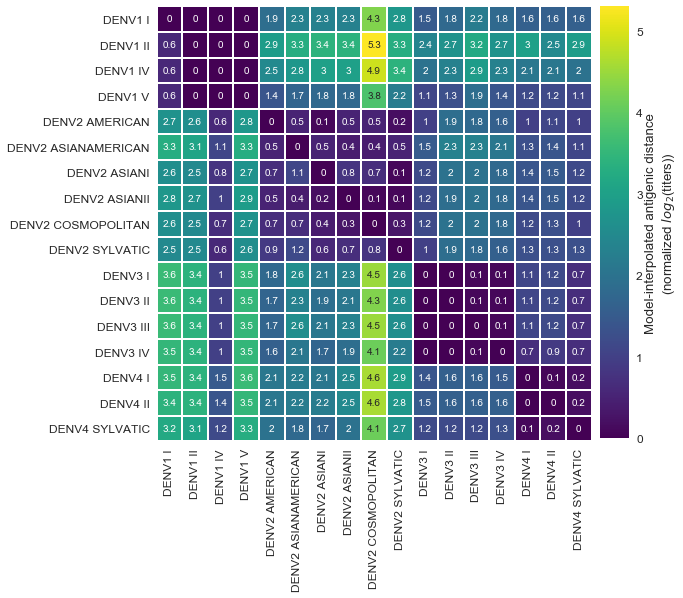

In [29]:
def plot_heatmap(distances, resolution, out_path = None):
    
    df = pd.DataFrame(distances).round(1)
    
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    genotypes = [c for c in df.columns.values if c not in serotypes]
    
    if resolution=='genotype':
        df = df.loc[genotypes, genotypes]
    else:
        df = df.loc[serotypes, serotypes]

    df.rename(columns={k :k.replace('_', ' ') for k in df.columns.values},
                         index={k :k.replace('_', ' ') for k in df.columns.values},
                         inplace=True)
    
    fig, ax = plt.subplots(1, 1,figsize=(8,8))
    cbar_ax = fig.add_axes([.905, 0.13, .05, .75])

    sns.set(font_scale=1.3)
    sns.heatmap(df, cmap='viridis', annot=True, square=True,
                annot_kws={'fontsize': 10}, linewidths=1, ax=ax, cbar_ax=cbar_ax,
                cbar_kws={'label': r'Model-interpolated antigenic distance'+'\n'+r'(normalized $log_2$(titers))'})
    
    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
        
plot_heatmap(full_tree_distances, 'genotype', out_path = '../figures/png/genotype_dTiter_heatmap.png')

In [34]:
def get_nih_vaccine_dTiters(tree, aa_seqs=aa_seqs, 
                            antigenic_mutations=antigenic_mutations, 
                            antigenic_clusters=antigenic_clusters):
    
    NIH_vaccine_strains = {'DENV4': 'DENV4/DOMINICA/814669DELTA30/1981', 
                       'DENV2': 'DENV2/TONGA/DELTA30/1974', 
                       'DENV3': 'DENV3/INDONESIA/SLEMANDELTA30/1978', 
                       'DENV1': 'DENV1/NAURU/WESTERNPACIFICDELTA30/1974'}
    
    leaf_object = lambda strain: [k for k in tree.leaves if k.traits['strain'] == strain][0]
    NIH_vaccine_leaves = { sero: leaf_object(strain) for sero,strain in NIH_vaccine_strains.items()}
    
    for virus in tree.leaves:
        for serotype, vaccine in NIH_vaccine_leaves.items():
            Dij = get_Dij(sera=vaccine, virus=virus)
            virus.traits['%s_vaccine_dTiter'%serotype] = Dij
            
    return tree

tree = get_nih_vaccine_dTiters(tree)

47


In [35]:
for k in tree.Objects:
    k.traits['clade'] = str(k.traits['clade'])
tree_string = tree.toString(traits=['clade', 'genotype', 'serotype', 
                                        'DENV1_vaccine_dTiter', 'DENV2_vaccine_dTiter', 
                                         'DENV3_vaccine_dTiter', 'DENV4_vaccine_dTiter',
                                        'aa_muts'], numName=True, nexus=True)
open(out_path+'trees/titered_annotated_tree.nexus', 'w').write(tree_string)